## IMPORT LIBRARIES

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
from collections import defaultdict

## READ DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = []
labels = []
image_size = (64, 64)
training_path = "/content/drive/MyDrive/Training"

if not os.path.exists(training_path):
    print(f"Error: Training directory not found at {training_path}")
    exit(1)

displayed_images = defaultdict(bool)

## PRE-PROCESSING

In [ ]:
def preprocess_image(img):
    img_resized = cv2.resize(img, (64, 64))

    img_blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)
    img_blurred = cv2.medianBlur(img_blurred, 5)

    gray_img = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2GRAY)

    enhanced_img = cv2.equalizeHist(gray_img)

    min_val, max_val = np.min(enhanced_img), np.max(enhanced_img)
    contrast_stretched_img = 255 * (enhanced_img - min_val) / (max_val - min_val)
    contrast_stretched_img = np.uint8(contrast_stretched_img)

    return contrast_stretched_img

## FEATURE EXTRACTION

In [ ]:
def extract_features(img):
    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    hog_features = hog.compute(img).flatten()

    return hog_features

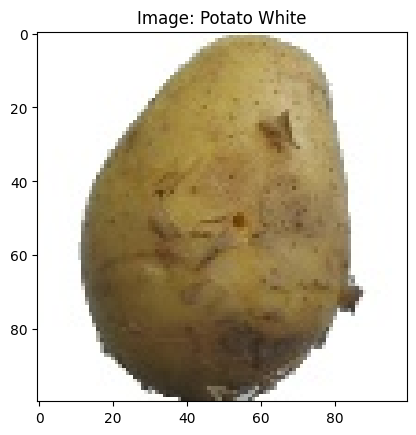

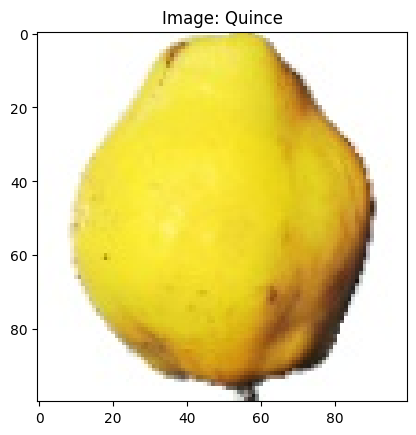

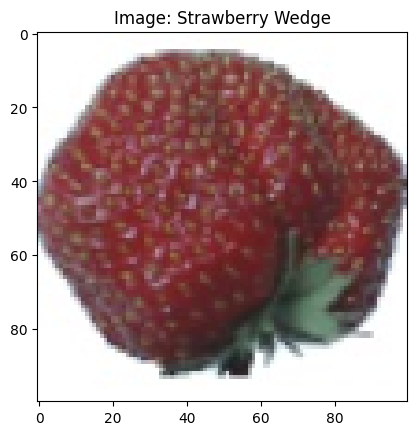

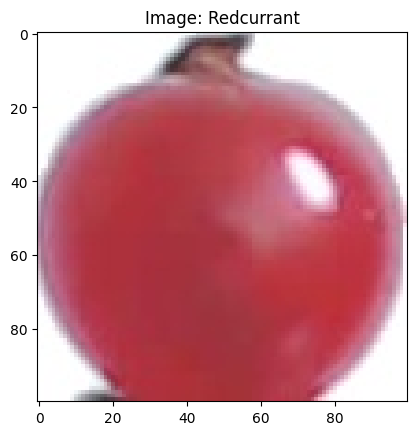

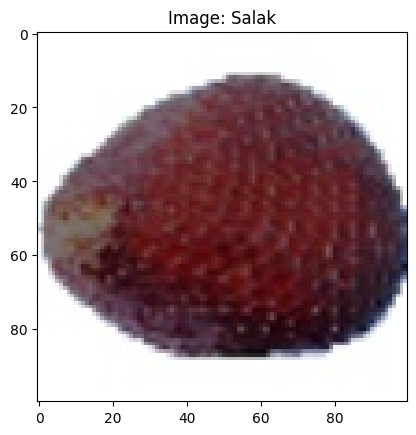

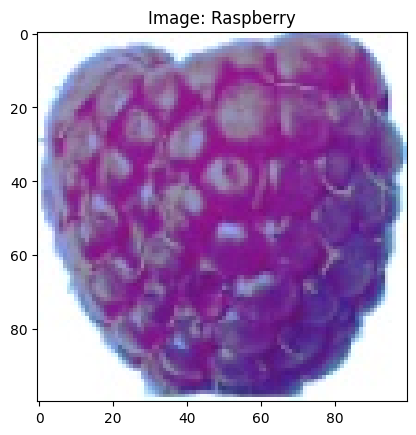

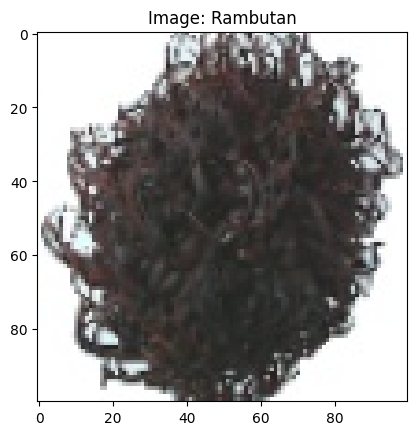

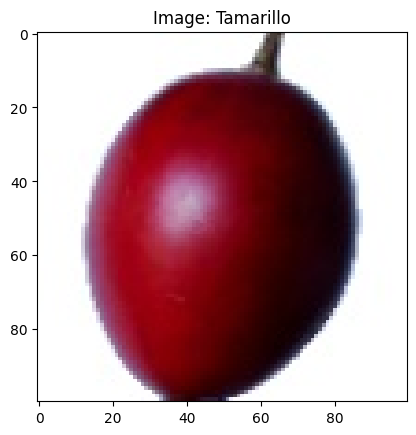

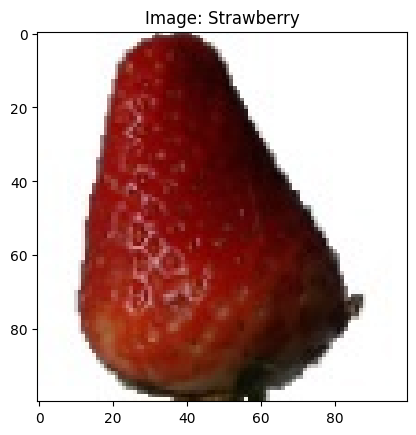

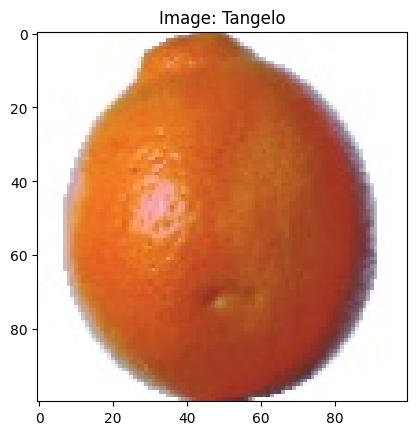

In [ ]:
for folder in os.listdir(training_path):
    folder_path = os.path.join(training_path, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, filename)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        processed_img = preprocess_image(img)

                        hog_features = extract_features(processed_img)

                        data.append(hog_features)
                        labels.append(folder)

                        if folder not in displayed_images:
                            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                            plt.title(f"Image: {folder}")
                            plt.show()
                            displayed_images[folder] = True
                    else:
                        print(f"Warning: Could not read image: {img_path}")
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")

## CLASSIFICATION

In [ ]:
if len(data) > 0:
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.1, 1]
    }

    grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

    grid_search.fit(X_train, y_train)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-validation Accuracy: {grid_search.best_score_}")

    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_test)

else:
    print("Error: No image data found. Check dataset and path.")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-validation Accuracy: 0.7166975648638241


## POST-PROCESSING

In [ ]:
if len(data) > 0:
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{cm}")
else:
    print("Error: Model evaluation failed. Check the dataset and pre-processing steps.")

Accuracy: 0.7018572825024438
Classification Report:
                  precision    recall  f1-score   support

    Potato White       0.97      0.87      0.92       103
          Quince       0.78      0.87      0.82       107
        Rambutan       0.74      0.30      0.43        87
       Raspberry       0.74      0.66      0.70        86
      Redcurrant       0.33      1.00      0.49        97
           Salak       0.87      0.81      0.84       100
      Strawberry       0.97      0.64      0.77        94
Strawberry Wedge       0.86      0.65      0.74       137
       Tamarillo       0.94      0.31      0.47       105
         Tangelo       0.87      0.86      0.86       107

        accuracy                           0.70      1023
       macro avg       0.81      0.70      0.70      1023
    weighted avg       0.81      0.70      0.71      1023

Confusion Matrix:
[[90  0  0  0  9  3  0  1  0  0]
 [ 0 93  0  1  1  1  0  2  0  9]
 [ 0  2 26  3 47  2  0  6  1  0]
 [ 0  7  2 57  7